### Classificação de textos para análise de sentimentos

O código é baseado no projeto do keaggle: base: https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch

Base de dados 

Istruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 01-08-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

In [1]:
!pip install torchtext

In [2]:
from torchtext import datasets
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Se tivermos uma GPU disponível, definiremos nosso dispositivo para GPU. Usaremos essa variável de dispositivo posteriormente em nosso código. A GPU foi ativada no google colab, na opção de Editar > Configuração do Notebook

In [21]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Montar Drive para os arquivos.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Baixar os dados

In [4]:
train_iter, test_iter = datasets.IMDB()

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:00<00:00, 92.8MB/s]


In [5]:
ds_imdb = list(train_iter + test_iter)
df = pd.DataFrame(data=ds_imdb, columns=['sentiment', 'review'])
df.head()

,sentiment,review
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  object
 1   review     50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.describe()

,sentiment,review
count,50000,50000
unique,2,49582
top,pos,Loved today's show!!! It was a variety and not...
freq,25000,5


In [8]:
df.nunique()

sentiment        2
review       49582
dtype: int64

Divisão dos dados em treino e teste.

In [9]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


Gráfico de barras com a quantidade de registros

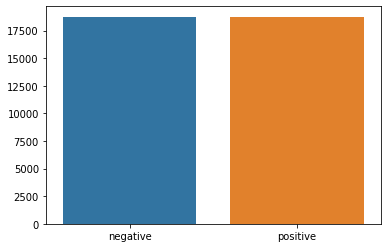

In [10]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [11]:
def preprocess_string(s):
    # Remova todos os caracteres que não sejam palavras (tudo exceto números e letras)
    s = re.sub(r"[^\w\s]", '', s)
    # Substituir todas os espaços em branco sem espaço
    s = re.sub(r"\s+", '', s)
    # Substituir dígitos sem espaço
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # classificar com base nas palavras mais comuns
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # criar um dicionário
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [12]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [13]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


Analisando a quantidade de reviews

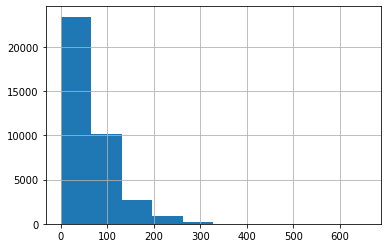

count    37500.000000
mean        69.321173
std         48.175022
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        655.000000
dtype: float64

In [14]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Preencher cada uma das sequências até o comprimento máximo

In [15]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [16]:
#Serão usados apenas os reviews com menos de 500 caracteres.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [17]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [18]:
# Obter uma amostra de dados para treinamento
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 174,  81, 888],
        [  0,   0,   0,  ..., 582, 232,  92],
        [  0,   0,   0,  ..., 111, 933,  20],
        ...,
        [  0,   0,   0,  ..., 756,  82, 699],
        [  0,   0,   0,  ..., 996, 114,  50],
        [  0,   0,   0,  ..., 203,  30, 247]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [19]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Crie dois novos tensores com tamanhos n_layers x batch_size x hidden_dim,
        # inicializado em zero, para hidden state e cell state do LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [22]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


Treino

In [23]:
# funções de perda e otimização
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# função para prever a acurácia
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [29]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        #Criando novas variáveis ​​para o estado oculto, caso contrário, teríamos backprop por todo o histórico de treinamento
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calcular a perda e executar backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # Calcular acurácia
        accuracy = acc(output,labels)
        train_acc += accuracy
        #'clip_grad_norm' ajuda a prevenir o problema de gradiente explosivo em RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 5.640541015736744e-07 val_loss : 3.576279254957626e-07
train_accuracy : 100.0 val_accuracy : 100.0
Validation loss decreased (inf --> 0.000000).  Saving model ...
Epoch 2
train_loss : 3.6727439148383684e-07 val_loss : 2.3841860752327193e-07
train_accuracy : 100.0 val_accuracy : 100.0
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch 3
train_loss : 2.41530784232206e-07 val_loss : 1.788139485370266e-07
train_accuracy : 100.0 val_accuracy : 100.0
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch 4
train_loss : 1.6189100838914783e-07 val_loss : 1.1920930376163597e-07
train_accuracy : 100.0 val_accuracy : 100.0
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch 5
train_loss : 1.0946910320323392e-07 val_loss : 5.960464477539063e-08
train_accuracy : 100.0 val_accuracy : 100.0
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


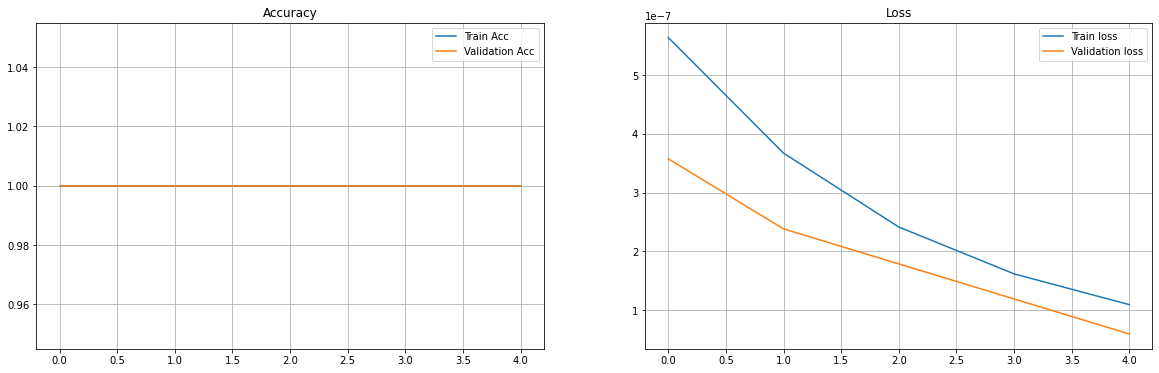

In [30]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [31]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [32]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

I have not seen many low budget films i must admit, but this is the worst movie ever probably, the main character the old man talked like, he had a lobotomy and lost the power to speak more than one word every 5 seconds, a 5 year old could act better. The story had the most awful plot, and well the army guy had put what he thought was army like and then just went over the top, i only watched it to laugh at how bad it was, and hoped it was leading onto the real movie. I cant believe it was under the 2 night rental thing at blockbusters, instead of a please take this for free and get it out of our sight. I think there was one semi decent actor other than the woman, i think the only thing OK with the budget was the make up, but they show every important scene of the film in the beginning music bit. Awful simply awful.
Actual sentiment is  : neg
Predicted sentiment is negative with a probability of 0.9999999332447018


In [33]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

You have to admire Brad Sykes even if you don't particularly want to, a man who churns out budget horror after budget horror to less than enthusiastic receptions. But keeps on doing it all the same. Even the half-hearted praise than surrounds his Camp Blood films is given grudgingly and I'm as guilty of this as anyone. Brad normally manages to throw something interesting into the mix, a neat idea, a kooky character, whatever, but without the funds to take it further than base level, he relies on the audience to cut him some slack and appreciate it for what it is and what it could be. Joe Haggerty gives a spirited and very funny performance as Ebenezer Jackson and its a credit to Sykes that he can sense that this oddball turn is going to work within the framework of the film. Coming to a multiplex near you, in a parallel universe, somewhere.
Actual sentiment is  : neg
predicted sentiment is negative with a probability of 0.9999999332494127
